##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 FGSM 的对抗样本

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/adversarial_fgsm"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/adversarial_fgsm.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程使用快速梯度符号法 (FGSM) 攻击（请参阅由 Goodfellow *等人*合著的 [Explaining and Harnessing Adversarial Example](https://arxiv.org/abs/1412.6572)）创建*对抗样本* 。这是第一种也是最受欢迎的能够欺骗神经网络的攻击算法之一。

## 什么是对抗样本？

对抗样本是以扰乱神经网络为目的而创建的专门输入，可导致给定输入被错误分类。这些臭名昭著的输入是肉眼无法区分的，但会导致网络无法识别图像的内容。这类攻击有多种类型，但这里重点讨论快速梯度符号法攻击，这是一种*白盒*攻击，其目的是确保错误分类。白盒攻击的特点是攻击者可以完全访问被攻击模型。下方显示的是对抗图像最著名的示例之一，该图取自上述论文。

![Adversarial Example](images/adversarial_example.png)

在这里，基于熊猫图像，攻击者向原始图像添加了较小的扰动（失真），这导致模型以较高的置信度将该图像标记为长臂猿。下文说明了添加这些扰动的过程。

## 快速梯度符号法

快速梯度符号法通过利用神经网络的梯度来创建对抗样本。对于输入图像，该方法使用相对于输入图像的损失梯度来创建损失最大化的新图像。此新图像被称为对抗图像。可以使用以下表达式予以总结：$$adv_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

其中

- adv_x：对抗图像。
- x：原始输入图像。
- y：原始输入标签。
- $\epsilon$：确保扰动很小的乘数。
- $\theta$：模型参数。
- $J$：损失。

这里有一个有趣的属性，梯度是相对于输入图像计算的。因为其目标是创建一个损失最大化的图像。一种实现此目的的方法是找出图像中每个像素对损失值的贡献程度，然后相应地添加一个扰动。这非常有效，因为通过使用链式法则并确定所需梯度，即可轻松地确定每个输入像素对损失的贡献。因此，梯度是相对于图像计算的。另外，由于不再对模型进行训练（因此，梯度计算值与可训练变量（即模型参数）无关），模型参数将保持恒定。唯一的目标是欺骗已经受过训练的模型。

那么，让我们来尝试欺骗一个经过预训练的模型。在本教程中，该模型为 [MobileNetV2](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) 模型，在 [ImageNet](http://www.image-net.org/) 上预训练。

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

2023-11-07 19:34:25.105529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 19:34:25.105569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 19:34:25.107270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


让我们加载预训练的 MobileNetV2 模型和 ImageNet 类名称。

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    8192/14536120 [..............................] - ETA: 0s

 8396800/14536120 [================>.............] - ETA: 0s

14536120/14536120 [==============================] - 0s 0us/step


In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## 原始图像

让我们使用这张[拉布拉多寻回犬](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)（拍摄者：Mirko，[CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)，Wikimedia Common），借此创建对抗样本。第一步是对其进行预处理，以便可以将其作为输入馈送至 MobileNetV2 模型。

In [5]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


让我们看一下图像。

 8192/35363 [=====>........................] - ETA: 0s

35363/35363 [==============================] - 0s 0us/step


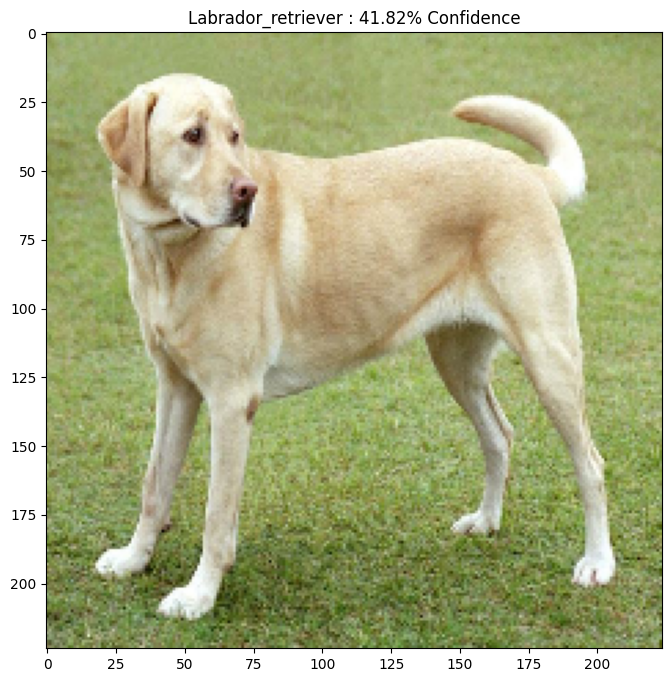

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## 创建对抗图像

### 实现快速梯度符号法

第一步是创建扰动，将用于使原始图像失真从而产生对抗图像。如上文所述，需要相对于图像来计算梯度。

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

由此产生的扰动也可以进行可视化。

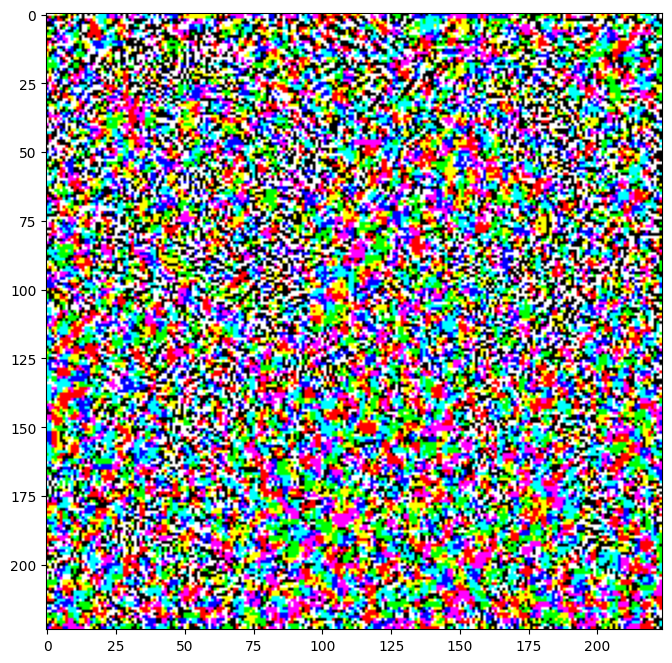

In [8]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

让我们尝试一下调整 ϵ 值，并观察结果图像。您会注意到，随着 ϵ 值的增大，欺骗网络变得更加容易。但需予以权衡，因为这会导致扰动变得更易被识别。

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


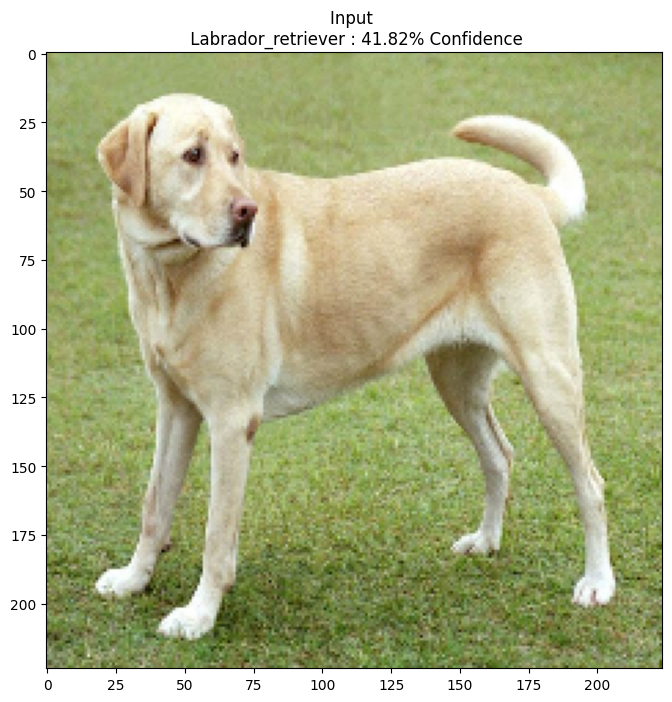

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


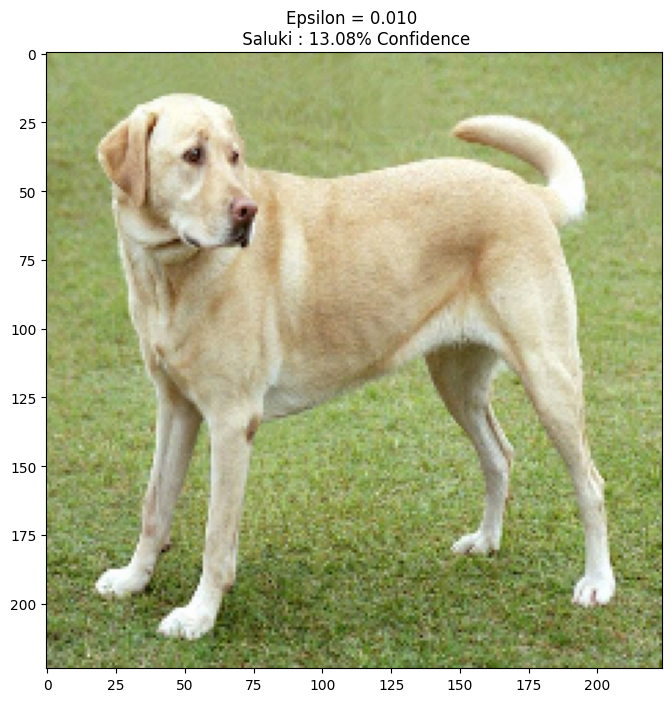

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


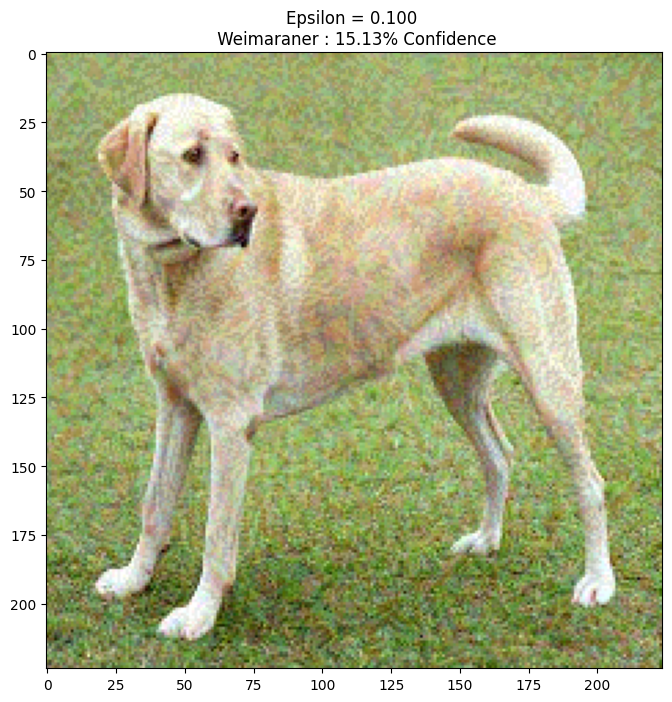

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


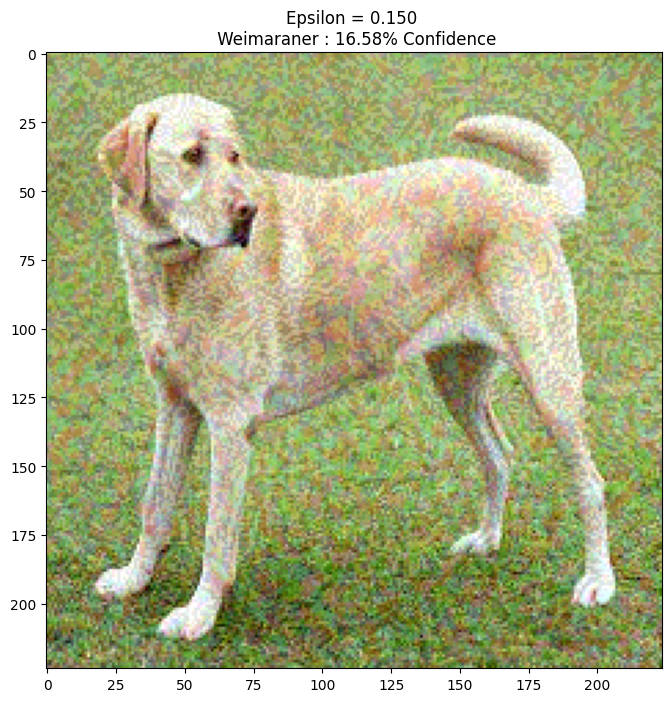

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## 后续步骤

现在，您已了解对抗攻击，请在不同的数据集和不同的架构上进行尝试。您也可以创建和训练自己的模型，然后尝试使用相同的方法来欺骗该模型。您还可以尝试查看更改 ϵ 值后预测的置信度将如何变化。

本教程中展示的攻击虽然强大，但也只是研究对抗攻击的开端，此后已有多篇论文创建了更为强大的攻击。除了对抗攻击之外，研究还延伸到防御的创建，旨在创建稳健的机器学习模型。您可以查看这篇[研究论文](https://arxiv.org/abs/1810.00069)来获取对抗攻击和防御的完整列表。

有关对抗攻击和防御的更多实现，您可以参见对抗示例库 [CleverHans](https://github.com/tensorflow/cleverhans)。